In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR

training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor())

test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from torch.utils.data import DataLoader

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 32, 32])
Shape of y:  torch.Size([64]) torch.int64


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

latent_space_size = 128
parallel_concepts = 7

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.layer_stack = nn.Sequential(
            nn.Linear(32*32*3, 2048),
            nn.ReLU(),
            #nn.Linear(2048, 1024),
            #nn.ReLU(),
            #nn.Linear(1024, 2048),
            #nn.ReLU(),
            nn.Linear(2048, 32*32*3)
        )

    def forward(self, x):
        x = self.flatten(x)
        reconstruction = self.layer_stack(x)
        reconstruction = torch.reshape(reconstruction, (-1, 3, 32, 32))
        return reconstruction

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_stack): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=3072, bias=True)
  )
)


In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.820340  [    0/50000]
loss: 0.611137  [ 6400/50000]
loss: 0.061102  [12800/50000]
loss: 0.049449  [19200/50000]
loss: 0.053252  [25600/50000]
loss: 0.055815  [32000/50000]
loss: 0.052857  [38400/50000]
loss: 0.049313  [44800/50000]
Test Error: Avg loss: 0.051055 

Epoch 2
-------------------------------
loss: 0.051918  [    0/50000]
loss: 0.047514  [ 6400/50000]
loss: 0.041873  [12800/50000]
loss: 0.041734  [19200/50000]
loss: 0.043788  [25600/50000]
loss: 0.047399  [32000/50000]
loss: 0.044782  [38400/50000]
loss: 0.042889  [44800/50000]
Test Error: Avg loss: 0.043045 

Epoch 3
-------------------------------
loss: 0.043450  [    0/50000]
loss: 0.043276  [ 6400/50000]
loss: 0.038224  [12800/50000]
loss: 0.040000  [19200/50000]
loss: 0.042054  [25600/50000]
loss: 0.046006  [32000/50000]
loss: 0.043439  [38400/50000]
loss: 0.039631  [44800/50000]
Test Error: Avg loss: 0.036928 

Epoch 4
-------------------------------
loss: 0.037629  [    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


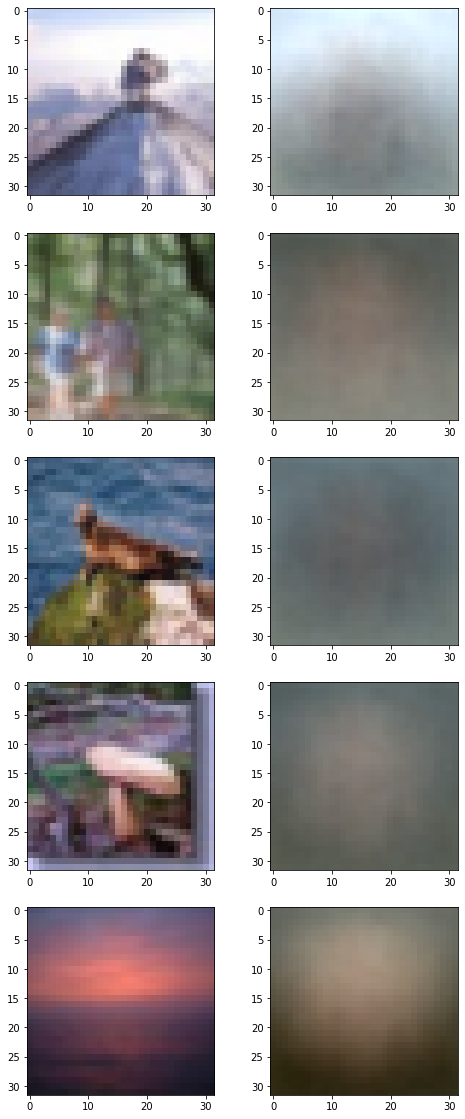

In [14]:
%matplotlib inline 
from matplotlib import pyplot as plt

img_count = 5
input_data_arr = [None]*img_count
reconstruction_arr = [None]*img_count
for X, y in test_dataloader:
    for i in range(img_count):
        input_data_arr[i] = X[i,:,:,:].permute(1, 2, 0)
    X = X.to(device)
    reconstruction = model(X)
    for i in range(img_count):
        reconstruction_arr[i] = reconstruction[i,:,:,:].permute(1, 2, 0)
    break

_, axarr = plt.subplots(img_count, 2, figsize=(8, 20))
for i in range(img_count):
    axarr[i, 0].imshow(input_data_arr[i], interpolation='nearest')
    axarr[i, 1].imshow(reconstruction_arr[i].detach().numpy(), interpolation='nearest')
plt.show()